In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcol
import cartopy.crs as ccrs
import cmocean
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.optimize as scopt
from functools import partial
import viz
import mplRC
import extremespaper as ex
import os
import warnings
mplRC.paperRC2();

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy312dc/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
    warnings.filterwarnings(action='ignore',
                            message='Mean of empty slice',
                            category=RuntimeWarning)
    warnings.filterwarnings(action='ignore',
                            message='invalid value encountered in log',
                            category=RuntimeWarning)

In [3]:
exdir=ex.exdirs
varlist=['tos','omega_arag_0','hplusos','spco2',]#'o2_mean_100_600']#,'intpp']
freq='daily'
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']

stats=ex.load_stats(scenList,varlist,freq=freq)

ffi=stats['ESM4_historical_D1']['omega_arag_0']
wgt=xr.DataArray(data=viz.areacello1x1,
            coords={'lat': ffi.lat,'lon': ffi.lon}, 
            dims=["lat", "lon"])#.stack(xy=['lat','lon'])
wgt=wgt*1e-6 # convert m2 to km2
wgt

<xarray.DataArray (lat: 180, lon: 360)> Size: 259kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [540.7215  , 540.74316 , 540.76685 , ..., 540.64636 , 540.6705  ,
        540.69543 ],
       [324.41064 , 324.45337 , 324.49612 , ..., 324.29257 , 324.33163 ,
        324.3709  ],
       [107.05158 , 107.16679 , 107.280174, ..., 106.71161 , 106.818886,
        106.935616]], shape=(180, 360), dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

In [4]:
stats['ESM4_historical_D1']['tos']

<xarray.Dataset> Size: 12GB
Dimensions:      (time: 1, lat: 180, lon: 360, quantile: 13, b: 2, YD: 365,
                  YD5: 73)
Coordinates:
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon          (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time         (time) object 8B 1995-01-01 00:00:00
  * YD           (YD) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * quantile     (quantile) float64 104B 0.0 0.02 0.05 0.07 ... 0.95 0.98 1.0
  * b            (b) int64 16B 0 1
  * YD5          (YD5) int64 584B 1 6 11 16 21 26 31 ... 336 341 346 351 356 361
Data variables: (12/22)
    mean         (time, lat, lon) float32 259kB ...
    var          (time, lat, lon) float32 259kB ...
    qt           (quantile, lat, lon) float64 7MB ...
    linfitcoef   (b, lat, lon) float64 1MB ...
    binseas      (YD, lat, lon) float64 189MB ...
    seas         (YD, lat, lon) float64 189MB ...
    ...           ...
    ydqt_ds2     (YD5, quantile, lat, lon) float64 492MB ...
    ydqt_dtds2   (YD5, quantile, lat, lon) float64 492MB ...
    ydqt2S       (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dt2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_ds2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dtds2S  (YD, quantile, lat, lon) float64 2GB ...
Attributes:
    long_name:                   Sea Surface Temperature
    units:                       degC
    standard_name:               sea_surface_temperature
    original_name:               tos
    varname:                     tos
    year-day quantile Descript:  full series fits are applied to dt and ds va...
    ydqt halfwindow:             2

In [5]:
devs=dict()
scen='ESM4_historical_D1'
qqh=.95
qql=.05
for ivar in varlist:
    qq=qqh if exdir[ivar]>0 else qql
    with xr.open_dataset(ex.fNameAnnualExtremes(scen,ex.dictScenDates[scen],freq,ivar)) as ff:
        #display(ff)
        devs[(scen,ivar)]=ff['an_mean_dt'].std(dim='year').load()

In [6]:
def _repl(fig,ax): # replace axes projection axes with normal axes
    pos=ax.get_position()
    ax.remove()
    ax=fig.add_axes(pos.bounds)#[0],0.1,.01,0.8
    return ax

In [7]:
cm1=cmocean.cm.haline
cm1.set_bad('k',alpha=0)
cmb=cmocean.cm.balance
cmb.set_bad('tan',alpha=0)
lons=viz.lonvec1x1
lats=viz.latvec1x1
#proj=ccrs.Robinson(central_longitude=-180)
proj=ccrs.Robinson(central_longitude=-150)#-170
#cnorm=mcol.CenteredNorm(vcenter=0)

In [8]:
varLabels={'tos':'SST (°C)','hplusos':'Surface\nH$^+$ (μM)','omega_arag_0':'Surface \n$\Omega _a$',
           'o2_mean_100_600': '100-600m Mean\nO$_2$ (mol m$^{-3}$)','intpp':'Integrated PP\n (mol m$^{-2}$s$^{-1}$)',
          'spco2':'Surface\npCO$_2$ (μatm)'}
scenLabels={'ESM4_ssp126_D1':'SSP1-2.6','ESM4_ssp370_D1':'SSP3-7.0',
            'ESM4_ssp534-over_D1':'SSP5-3.4-OS',
           'hist':'Historical','126':'SSP1-2.6','245':'SSP2-4.5','370':'SSP3-7.0'}

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
/tmp/reo000/3451154/ipykernel_762800/2512461534.py:1: SyntaxWarning: invalid escape sequence '\O'
  varLabels={'tos':'SST (°C)','hplusos':'Surface\nH$^+$ (μM)','omega_arag_0':'Surface \n$\Omega _a$',


In [9]:

deltaH=stats['ESM4_ssp370_D1']['hplusos']['mean_dt'].isel(time=0)-\
                stats['ESM4_historical_D1']['hplusos']['mean_dt'].isel(time=0)
deltapC=(stats['ESM4_ssp370_D1']['spco2']['mean_dt'].isel(time=0)-\
                stats['ESM4_historical_D1']['spco2']['mean_dt'].isel(time=0))*1e6/101325
deltaOm=stats['ESM4_ssp370_D1']['omega_arag_0']['mean_dt'].isel(time=0)-\
                stats['ESM4_historical_D1']['omega_arag_0']['mean_dt'].isel(time=0)

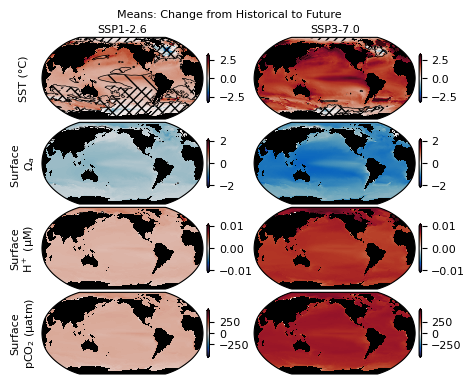

In [10]:
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']
fig,ax=plt.subplots(5,3,figsize=(5.5,4.5),
                    subplot_kw={'projection':proj,'facecolor':'black'},
                    gridspec_kw={'hspace':.05,'wspace':.1,'height_ratios':[.08,1,1,1,1],'width_ratios':[.01,1,1]})
ax[0,0].remove()
for fi in range(1,3):
    ax[0,fi]=_repl(fig,ax[0,fi])
    ax[0,fi].text(-.45,.7,scenLabels[scenList[fi]],ha='center',va='center')#
    ax[0,fi].set_xlim(-.1,.1)
    #ax[0,fi].set_ylim(-1,1)
    ax[0,fi].set_axis_off()
for fj in range(1,5):
    ax[fj,0]=_repl(fig,ax[fj,0])
    ax[fj,0].text(.5,.5,varLabels[varlist[fj-1]],ha='center',va='center',rotation='vertical')
    ax[fj,0].set_axis_off()
extremes={}
vm={1:3,2:2,3:.01,4:50*1e6/101325}
for fi in range(1,3):
    for fj in range(1,5):
        scen=scenList[fi]
        ivar=varlist[fj-1]
        A=1e6/101325 if ivar=='spco2' else 1
        #qq=qqh if exdir[ivar]>0 else qql
        delta=(stats[scen][ivar]['mean_dt'].isel(time=0)-\
                stats['ESM4_historical_D1'][ivar]['mean_dt'].isel(time=0))*A
        m=ax[fj,fi].pcolormesh(lons,lats,delta,transform=ccrs.PlateCarree(),cmap=cmb,
                               norm=mcol.CenteredNorm(vcenter=0,
                                    halfrange=vm[fj]))#2.5*np.sqrt(np.nansum(delta*delta)/np.sum(~np.isnan(delta)))))
        cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,extend='both',pad=.02)
        ratio1=delta/devs[('ESM4_historical_D1',ivar)]*exdir[ivar]
        ratio2=delta/np.average(np.ma.masked_where(np.isnan(delta),devs[('ESM4_historical_D1',ivar)]),weights=wgt.fillna(0))*exdir[ivar]
        ax[fj,fi].contour(lons,lats,ratio1,levels=[2,],
                         transform=ccrs.PlateCarree(),
                         linewidths=.5,colors='k')
        mh1=ax[fj,fi].contourf(lons,lats,ratio1,levels=[-100,2,3],
                         transform=ccrs.PlateCarree(),
                         extend='max',colors='none',
                   hatches=['\\\\',None, None,])
        mh2=ax[fj,fi].contourf(lons,lats,ratio2,levels=[-100,2,3],
                         transform=ccrs.PlateCarree(),
                         extend='max',colors='none',
                   hatches=['////',None,None,])

fig.suptitle('Means: Change from Historical to Future',y=.92);

#fig.savefig('delta_mean.png',dpi=300,bbox_inches='tight')

In [11]:
exdir

{'tos': 1, 'hplusos': 1, 'phos': -1, 'omega_arag_0': -1, 'spco2': 1}

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
/tmp/reo000/3451154/ipykernel_762800/3867514791.py:33: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('$\Delta$(95$^{th}$ Percentile - Mean) from Historical to Future',y=.92);


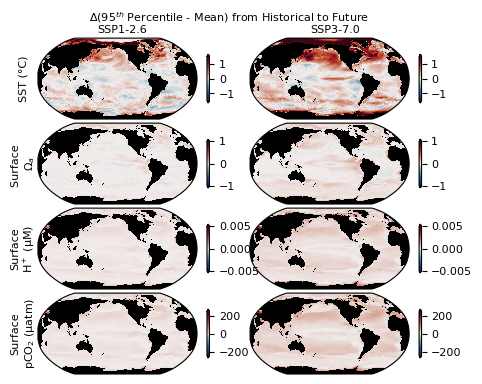

In [12]:
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']
fig,ax=plt.subplots(5,3,figsize=(5.5,4.5),
                    subplot_kw={'projection':proj,'facecolor':'black'},
                    gridspec_kw={'hspace':.05,'wspace':.1,'height_ratios':[.08,1,1,1,1],'width_ratios':[.01,1,1]})

ax[0,0].remove()
#ax[4,0].remove()
for fi in range(1,3):
    ax[0,fi]=_repl(fig,ax[0,fi])
    ax[0,fi].text(-.45,.7,scenLabels[scenList[fi]],ha='center',va='center')#
    ax[0,fi].set_xlim(-.1,.1)
    ax[0,fi].set_axis_off()
for fj in range(1,5):
    ax[fj,0]=_repl(fig,ax[fj,0])
    ax[fj,0].text(.5,.5,varLabels[varlist[fj-1]],ha='center',va='center',rotation='vertical')
    ax[fj,0].set_axis_off()
extremes={}
vm={1:3/2,2:2/2,3:.01/2,4:50*1e6/101325/2}
for fi in range(1,3):
    for fj in range(1,5):
        scen=scenList[fi]
        ivar=varlist[fj-1]
        A=1e6/101325 if ivar=='spco2' else 1
        qq = qqh if exdir[ivar]>0 else qql
        delta=(stats[scen][ivar]['qt_dt'].sel(quantile=qq)-\
                stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq)-(stats[scen][ivar]['mean_dt'].isel(time=0)-\
                stats['ESM4_historical_D1'][ivar]['mean_dt'].isel(time=0)))*A
        m=ax[fj,fi].pcolormesh(lons,lats,delta,transform=ccrs.PlateCarree(),cmap=cmb,
                               norm=mcol.CenteredNorm(vcenter=0,
                                    halfrange=vm[fj]))#2.5*np.sqrt(np.nansum(delta*delta)/np.sum(~np.isnan(delta)))))
        cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,extend='both')

fig.suptitle('$\Delta$(95$^{th}$ Percentile - Mean) from Historical to Future',y=.92);
#fig.savefig('delta_95meandiff.png',dpi=300,bbox_inches='tight')

<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
/tmp/reo000/3451154/ipykernel_762800/3792487607.py:32: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('$\Delta$(Deseasonalized 95$^{th}$ Percentile - Mean) from Historical to Future',y=.92);


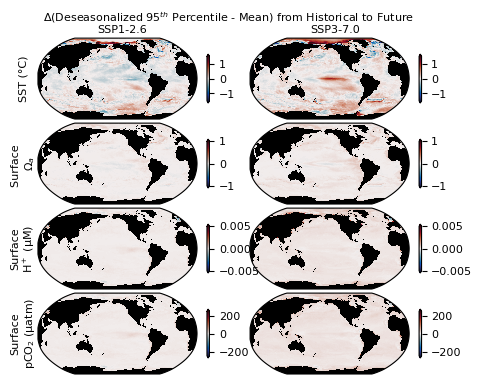

In [13]:
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']
fig,ax=plt.subplots(5,3,figsize=(5.5,4.5),
                    subplot_kw={'projection':proj,'facecolor':'black'},
                    gridspec_kw={'hspace':.05,'wspace':.1,'height_ratios':[.08,1,1,1,1],'width_ratios':[.01,1,1]})

ax[0,0].remove()
#ax[4,0].remove()
for fi in range(1,3):
    ax[0,fi]=_repl(fig,ax[0,fi])
    ax[0,fi].text(-.45,.7,scenLabels[scenList[fi]],ha='center',va='center')#
    ax[0,fi].set_xlim(-.1,.1)
    ax[0,fi].set_axis_off()
for fj in range(1,5):
    ax[fj,0]=_repl(fig,ax[fj,0])
    ax[fj,0].text(.5,.5,varLabels[varlist[fj-1]],ha='center',va='center',rotation='vertical')
    ax[fj,0].set_axis_off()
extremes={}
vm={1:3/2,2:2/2,3:.01/2,4:50*1e6/101325/2}
for fi in range(1,3):
    for fj in range(1,5):
        scen=scenList[fi]
        ivar=varlist[fj-1]
        A=1e6/101325 if ivar=='spco2' else 1
        qq = qqh if exdir[ivar]>0 else qql
        delta=(stats[scen][ivar]['qt_dtds'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dtds'].sel(quantile=qq)-\
               (stats[scen][ivar]['mean_dtds'].isel(time=0)-stats['ESM4_historical_D1'][ivar]['mean_dtds'].isel(time=0)))*A
        m=ax[fj,fi].pcolormesh(lons,lats,delta,transform=ccrs.PlateCarree(),cmap=cmb,
                               norm=mcol.CenteredNorm(vcenter=0,
                                    halfrange=vm[fj]))#2.5*np.sqrt(np.nansum(delta*delta)/np.sum(~np.isnan(delta)))))
        cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,extend='both')

fig.suptitle('$\Delta$(Deseasonalized 95$^{th}$ Percentile - Mean) from Historical to Future',y=.92);
#fig.savefig('delta_95meandiff_deseas.png',dpi=300,bbox_inches='tight')

In [14]:
def _forward(x):
    return np.log(x)
def _inverse(x):
    return np.exp(x)
fnorm3 = mcol.FuncNorm((_forward, _inverse), vmin=1/3, vmax=3)
fnorm2 = mcol.FuncNorm((_forward, _inverse), vmin=1/2, vmax=2)

<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
/tmp/reo000/3451154/ipykernel_762800/1775417723.py:46: SyntaxWarning: invalid escape sequence '\D'
  fig.suptitle('Ratio: $\Delta$ 95$^{th}$ Percentile / $\Delta$ Mean from Historical to Future',y=.92);


tos ESM4_ssp126_D1 Area-weighted median ratio of 95th(5th) to mean: 1.0494325451690634
tos ESM4_ssp126_D1 Area-weighted quantiles of ratio of 95th(5th) to mean: [0.86259141 0.91977291 1.04943255 1.24515949 1.37100516]
omega_arag_0 ESM4_ssp126_D1 Area-weighted median ratio of 95th(5th) to mean: 0.991307894963405
omega_arag_0 ESM4_ssp126_D1 Area-weighted quantiles of ratio of 95th(5th) to mean: [0.92114198 0.94858565 0.99130789 1.01865654 1.03190123]
hplusos ESM4_ssp126_D1 Area-weighted median ratio of 95th(5th) to mean: 1.060995336514876
hplusos ESM4_ssp126_D1 Area-weighted quantiles of ratio of 95th(5th) to mean: [1.02740301 1.03912456 1.06099534 1.09237224 1.11198345]
spco2 ESM4_ssp126_D1 Area-weighted median ratio of 95th(5th) to mean: 1.070407166558315
spco2 ESM4_ssp126_D1 Area-weighted quantiles of ratio of 95th(5th) to mean: [1.03242797 1.04416005 1.07040717 1.10600663 1.12627718]
tos ESM4_ssp370_D1 Area-weighted median ratio of 95th(5th) to mean: 1.0846782588439796
tos ESM4_ssp37

/tmp/reo000/3451154/ipykernel_762800/1995336151.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/tmp/reo000/3451154/ipykernel_762800/1995336151.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/tmp/reo000/3451154/ipykernel_762800/1995336151.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/tmp/reo000/3451154/ipykernel_762800/1995336151.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/tmp/reo000/3451154/ipykernel_762800/1995336151.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


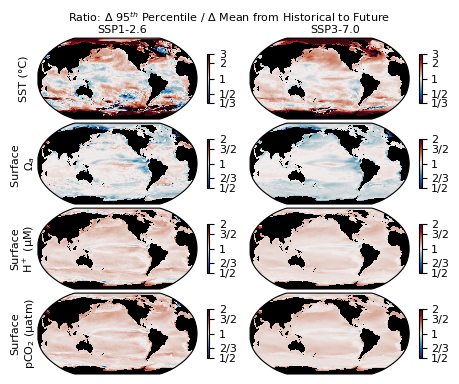

In [15]:
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']
fig,ax=plt.subplots(5,3,figsize=(5.5,4.5),
                    subplot_kw={'projection':proj,'facecolor':'black'},
                    gridspec_kw={'hspace':.05,'wspace':.1,'height_ratios':[.08,1,1,1,1],'width_ratios':[.01,1,1]})

ax[0,0].remove()
#ax[4,0].remove()
for fi in range(1,3):
    ax[0,fi]=_repl(fig,ax[0,fi])
    ax[0,fi].text(-.45,.7,scenLabels[scenList[fi]],ha='center',va='center')#
    ax[0,fi].set_xlim(-.1,.1)
    ax[0,fi].set_axis_off()
for fj in range(1,5):
    ax[fj,0]=_repl(fig,ax[fj,0])
    ax[fj,0].text(.5,.5,varLabels[varlist[fj-1]],ha='center',va='center',rotation='vertical')
    ax[fj,0].set_axis_off()
extremes={}
vm={1:3/2,2:2/2,3:.01/2,4:50*1e6/101325/2}
for fi in range(1,3):
    for fj in range(1,5):
        scen=scenList[fi]
        ivar=varlist[fj-1]
        A=1e6/101325 if ivar=='spco2' else 1
        #print(ivar,A)
        qq = qqh if exdir[ivar]>0 else qql
        delta95=(stats[scen][ivar]['qt_dt'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))*A
        deltamean=(stats[scen][ivar]['mean_dt'].isel(time=0)-stats['ESM4_historical_D1'][ivar]['mean_dt'].isel(time=0))*A
        rat=delta95/deltamean
        d=np.ndarray.flatten(delta95.values)
        x=np.ndarray.flatten(rat.values)
        x[np.isnan(x)]=0
        w=np.ndarray.flatten(wgt.fillna(0).values)
        wmed1=np.quantile(x[~np.isnan(d)],[.16,.25,.5,.75,.84],weights=w[~np.isnan(d)],method='inverted_cdf')
        wmed=np.quantile(x[~np.isnan(d)],.5,weights=w[~np.isnan(d)],method='inverted_cdf')
        print(ivar,scen,'Area-weighted median ratio of 95th(5th) to mean:',wmed)
        print(ivar,scen,'Area-weighted quantiles of ratio of 95th(5th) to mean:',wmed1)
        if ivar=='tos':
            m=ax[fj,fi].pcolormesh(lons,lats,rat,transform=ccrs.PlateCarree(),norm=fnorm3,cmap=cmb)
            cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,ticks=[1/3,1/2,1,2,3])
            cb.ax.set_yticklabels(['1/3','1/2','1','2','3'])
        else:
            m=ax[fj,fi].pcolormesh(lons,lats,rat,transform=ccrs.PlateCarree(),norm=fnorm2,cmap=cmb)
            cb=fig.colorbar(m,ax=ax[fj,fi],shrink=.6,ticks=[1/2,2/3,1,3/2,2])
            cb.ax.set_yticklabels(['1/2','2/3','1','3/2','2'])

fig.suptitle('Ratio: $\Delta$ 95$^{th}$ Percentile / $\Delta$ Mean from Historical to Future',y=.92);
fig.savefig('delta_95mean_ratio.png',dpi=300,bbox_inches='tight')

In [21]:
# organize data in dictionary
# PctAT=pcercent of area*time meeting stress threshold:
# SC=seasonally constant; SV= seasonally varying; RF= fixed reference; RA= adaptive reference
# other categories: DHW, OA1, OA3
# variables/combos: tos, hplusos, omega_arag_0
#ff[(lkey,iscen,ivar)]
masks=ex.loadMasks()
vals={}
for iscen in ['ESM4_ssp126_D1','ESM4_ssp370_D1']:
    for ivar in varlist:
        print(ivar,iscen)
        A=1e6/101325 if ivar=='spco2' else 1
        #print(ivar,A)
        qq = qqh if ex.exdirs[ivar]>0 else qql
        delta95=(stats[iscen][ivar]['qt_dt'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))*A
        deltamean=(stats[iscen][ivar]['mean_dt'].isel(time=0)-stats['ESM4_historical_D1'][ivar]['mean_dt'].isel(time=0))*A
        rat=delta95/deltamean
        d=np.ndarray.flatten(deltamean.values)#d=np.ndarray.flatten(delta95.values)
        x=np.ndarray.flatten(rat.values)
        #x[np.isnan(x)]=0
        w=np.ndarray.flatten(wgt.fillna(0).values)
        danamp=(stats[iscen][ivar].binseas.max(dim='YD')-stats[iscen][ivar].binseas.min(dim='YD'))/2-\
                (stats['ESM4_historical_D1'][ivar].binseas.max(dim='YD')-stats['ESM4_historical_D1'][ivar].binseas.min(dim='YD'))/2
        for lkey in masks.keys():
            vals[(lkey,iscen,ivar,'dmean')]=np.sum(np.sum(masks[lkey].mask*deltamean.values*wgt.fillna(0)))/np.sum(np.sum(masks[lkey].mask*wgt.fillna(0)))
            vals[(lkey,iscen,ivar,'dseas')]=np.sum(np.sum(masks[lkey].mask*danamp.values*wgt.fillna(0)))/np.sum(np.sum(masks[lkey].mask*wgt.fillna(0)))
            vals[(lkey,iscen,ivar,'dp95')]=np.sum(np.sum(masks[lkey].mask*delta95.values*wgt.fillna(0)))/np.sum(np.sum(masks[lkey].mask*wgt.fillna(0)))
            m=np.ndarray.flatten(masks[lkey].mask==1)
            #print(x[(~np.isnan(d))&m])
            wmed=np.quantile(x[(~np.isnan(d))&m],.5,weights=w[(~np.isnan(d))&m],method='inverted_cdf')
            print(ivar,iscen,lkey,'Area-weighted median ratio of 95th(5th) to mean:',wmed)


tos ESM4_ssp126_D1
tos ESM4_ssp126_D1 NE Canyons Area-weighted median ratio of 95th(5th) to mean: 1.417770955990247
tos ESM4_ssp126_D1 Monterey Bay Area-weighted median ratio of 95th(5th) to mean: 1.245037468981107
tos ESM4_ssp126_D1 FL Keys Area-weighted median ratio of 95th(5th) to mean: 1.08339995345997
tos ESM4_ssp126_D1 La Parg Area-weighted median ratio of 95th(5th) to mean: 0.9175342333338464
tos ESM4_ssp126_D1 Isla de Mona Area-weighted median ratio of 95th(5th) to mean: 0.9363738714554344
tos ESM4_ssp126_D1 Steller Area-weighted median ratio of 95th(5th) to mean: 1.2283258225184042
tos ESM4_ssp126_D1 Humpback Area-weighted median ratio of 95th(5th) to mean: 1.0998887481195596
tos ESM4_ssp126_D1 Pac Remote Area-weighted median ratio of 95th(5th) to mean: 0.9831314166662436
tos ESM4_ssp126_D1 Samoa Area-weighted median ratio of 95th(5th) to mean: 1.2932102394637737
tos ESM4_ssp126_D1 Marianas Area-weighted median ratio of 95th(5th) to mean: 0.9737386329299669
tos ESM4_ssp126_D1 

<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
/tmp/reo000/3451154/ipykernel_762800/3125395555.py:20: SyntaxWarning: invalid escape sequence '\D'
  rects1C=ax[ls].bar(xv-ww/2+ww*ind,vMe,ww,label=f'$\Delta$Mean, {scenLabels[iscen]}',bottom=bottomC,color='gold',alpha=aa[ind])#color=colors[(ivx2)][0]
/tmp/reo000/3451154/ipykernel_762800/3125395555.py:21: SyntaxWarning: invalid escape sequence '\D'
  rects1V=ax[ls].bar(xv-ww/4-ww/2+ww*ind,vAn,ww/2,label=f'$\Delta$Seasonal, {scenLabels[iscen]}',bottom=vMe,color='darkturquoise',alpha=aa[ind])
/tmp/reo000/3451154/ipykernel_762800/3125395555.py:22: SyntaxWarning: invalid escape sequence '\D'
  rects1V=ax[ls].bar(xv+ww/4-ww/2+ww*ind,v95,ww/2,label=f'$\Delta$95{th}, {scenLabels[iscen]}',bott

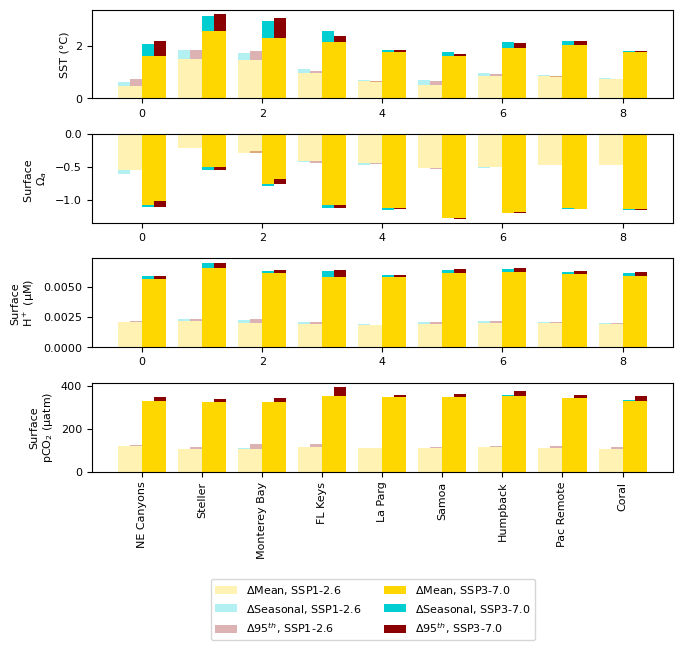

In [23]:
# first example: ESM4_ssp126_D1, NE Canyons
plist=['tos','omega_arag_0','hplusos','spco2',]
psites=['NE Canyons','Steller', 'Monterey Bay', 'FL Keys', 'La Parg', 'Samoa', 
        'Humpback', 'Pac Remote', 'Coral']
xv=np.arange(len(psites))
fig,ax=plt.subplots(4,1,figsize=(7.5,6),gridspec_kw={'hspace':.4,})
ww=0.4
ivx1='tos'
th='$^{th}$'
aa=[.3,1]
for ls,ivx2 in enumerate(plist):
    for ind, iscen in enumerate(['ESM4_ssp126_D1','ESM4_ssp370_D1']):
        
        bottomC=np.zeros(len(psites))
        bottomV=np.zeros(len(psites))
        vMe=[vals[(lkey,iscen,ivx2,'dmean')] for lkey in psites]
        vAn=[vals[(lkey,iscen,ivx2,'dseas')]*ex.exdirs[ivx2] for lkey in psites]
        v95=[vals[(lkey,iscen,ivx2,'dp95')]-vals[(lkey,iscen,ivx2,'dmean')] for lkey in psites]
        if ls==0:
            rects1C=ax[ls].bar(xv-ww/2+ww*ind,vMe,ww,label=f'$\Delta$Mean, {scenLabels[iscen]}',bottom=bottomC,color='gold',alpha=aa[ind])#color=colors[(ivx2)][0]
            rects1V=ax[ls].bar(xv-ww/4-ww/2+ww*ind,vAn,ww/2,label=f'$\Delta$Seasonal, {scenLabels[iscen]}',bottom=vMe,color='darkturquoise',alpha=aa[ind])
            rects1V=ax[ls].bar(xv+ww/4-ww/2+ww*ind,v95,ww/2,label=f'$\Delta$95{th}, {scenLabels[iscen]}',bottom=vMe,color='darkred',alpha=aa[ind])
        else:
            rects1C=ax[ls].bar(xv-ww/2+ww*ind,vMe,ww,bottom=bottomC,color='gold',alpha=aa[ind])#color=colors[(ivx2)][0]
            rects1V=ax[ls].bar(xv-ww/4-ww/2+ww*ind,vAn,ww/2,bottom=vMe,color='darkturquoise',alpha=aa[ind])
            rects1V=ax[ls].bar(xv+ww/4-ww/2+ww*ind,v95,ww/2,bottom=vMe,color='darkred',alpha=aa[ind])

        # if ls==0:
        #     ax[ls,ind].set_title(scenLabels[iscen])
    ax[ls].set_ylabel(varLabels[ivx2])
        #ax[ls,ind].set_ylim(0,100)
if ls==3:
    ax[ls].set_xticks(xv,psites,rotation=90)
else:
    ax[ls].set_xticks(xv)
    ax[ls].set_xticklabels('')

fig.legend(loc='lower center', ncols=2,bbox_to_anchor=[.5,-.18])
fig.savefig(f'MPASitesBarsDeltas.png',dpi=300,bbox_inches='tight')

## extinction versus extirpation: are similar waters available? base on Mean

contour=1155185.714029961; percent enclosed ~0.8143658062743779
contour=656229.1818646727; percent enclosed ~0.8994062612599625
contour=881913.6490229437; percent enclosed ~0.9018924023014501
contour=1297363.931536984; percent enclosed ~0.8984828322344387
contour=1405165.0511509383; percent enclosed ~0.9009720724622865
contour=1118988.6015321943; percent enclosed ~0.9052702187069591


<>:90: SyntaxWarning: invalid escape sequence '\O'
<>:90: SyntaxWarning: invalid escape sequence '\O'
/tmp/reo000/3451154/ipykernel_762800/900420655.py:90: SyntaxWarning: invalid escape sequence '\O'
  iax.set_xlabel('Surface $\Omega_a$',labelpad=0)


Text(0.5, 1.0, '   km$^2$')

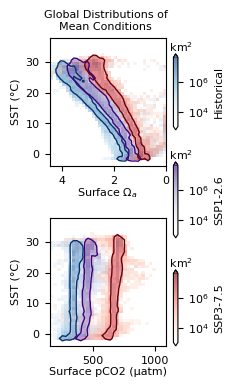

In [24]:


colors1 = plt.get_cmap('Blues')(np.linspace(0,1,10))
colors1[:,-1]=np.linspace(.2,.6,10)
colors2 = plt.get_cmap('Purples')(np.linspace(0,1,10))
colors2[:,-1]=np.linspace(.2,.6,10)
colors3 = plt.get_cmap('Reds')(np.linspace(0,1,10))
colors3[:,-1]=np.linspace(.2,.6,10)

cm1=mcol.LinearSegmentedColormap.from_list('cm1', colors1)
cm2=mcol.LinearSegmentedColormap.from_list('cm2', colors2)
cm3=mcol.LinearSegmentedColormap.from_list('cm3', colors3)

cm1.set_under('w',alpha=0)
cm2.set_under('w',alpha=0)
cm3.set_under('w',alpha=0)

ix=viz.wet1x1>0
cmax=50000000 #2100*np.sum(wgt.fillna(0).data[ix])/np.sum(ix)
lnorm=mcol.LogNorm(vmin=1000,vmax=cmax)
def _pfun(c,h0):
    return (np.sum(np.where(h0>=c,h0,0))/np.sum(h0)-.9)**2

def _getc(h):
    oo=scopt.minimize_scalar(partial(_pfun,h0=h),bounds=[0,np.max(h)])
    print(f'contour={oo.x}; percent enclosed ~{np.sum(np.where(h>=oo.x,h,0))/np.sum(h)}')
    return oo.x

omedges=np.linspace(0,5,41)
tedges=np.linspace(-5,40,47)
cedges=np.linspace(0,120,41)

fig,ax=plt.subplots(2,1,figsize=(1.5,4),gridspec_kw={'hspace':.4,'wspace':.4})
row=0
iscen='ESM4_historical_D1'
xx=stats[iscen]['omega_arag_0']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h1,xe1,ye1=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h1=h1*np.sum(ix)/np.sum(h1)
im1=ax[row].pcolormesh(xe1,ye1,h1.T,norm=lnorm,cmap=cm1,);
#ax[row].pcolormesh(xe1,ye1,h1.T,norm=lnorm,cmap=cm1,);
iscen='ESM4_ssp126_D1'
xx=stats[iscen]['omega_arag_0']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h2,xe2,ye2=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h2=h2*np.sum(ix)/np.sum(h2)
im2=ax[row].pcolormesh(xe2,ye2,h2.T,norm=lnorm,cmap=cm2);
iscen='ESM4_ssp370_D1'
xx=stats[iscen]['omega_arag_0']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h3,xe3,ye3=np.histogram2d(xx[ix],yy[ix],bins=[omedges,tedges],weights=wgt.fillna(0).data[ix])
#h3=h3*np.sum(ix)/np.sum(h3)
im3=ax[row].pcolormesh(xe3,ye3,h3.T,norm=lnorm,cmap=cm3);

ax[row].contour(.5*(xe1[:-1]+xe1[1:]),.5*(ye1[:-1]+ye1[1:]),h1.T,np.array([_getc(h1),]),
                  colors=[colors1[-1,:],],alpha=1)
ax[row].contour(.5*(xe2[:-1]+xe2[1:]),.5*(ye2[:-1]+ye2[1:]),h2.T,np.array([_getc(h2),]),
                  colors=[colors2[-1,:],],alpha=1)
ax[row].contour(.5*(xe3[:-1]+xe3[1:]),.5*(ye3[:-1]+ye3[1:]),h3.T,np.array([_getc(h3),]),
                  colors=[colors3[-1,:],],alpha=1)

row=1
iscen='ESM4_historical_D1'
xx=stats[iscen]['spco2']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h1,xe1,ye1=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h1=h1*np.sum(ix)/np.sum(h1)
im1=ax[row].pcolormesh(xe1*1e6/101325,ye1,h1.T,norm=lnorm,cmap=cm1,);
iscen='ESM4_ssp126_D1'
xx=stats[iscen]['spco2']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h2,xe2,ye2=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h2=h2*np.sum(ix)/np.sum(h2)
im2=ax[row].pcolormesh(xe2*1e6/101325,ye2,h2.T,norm=lnorm,cmap=cm2);
iscen='ESM4_ssp370_D1'
xx=stats[iscen]['spco2']['mean'].isel(time=0).values
yy=stats[iscen]['tos']['mean'].isel(time=0).values
h3,xe3,ye3=np.histogram2d(xx[ix],yy[ix],bins=[cedges,tedges],weights=wgt.fillna(0).data[ix])
#h3=h3*np.sum(ix)/np.sum(h3)
im3=ax[row].pcolormesh(xe3*1e6/101325,ye3,h3.T,norm=lnorm,cmap=cm3);

ax[row].contour(.5*1e6/101325*(xe1[:-1]+xe1[1:]),.5*(ye1[:-1]+ye1[1:]),h1.T,np.array([_getc(h1),]),
                  colors=[colors1[-1,:],],alpha=1)
ax[row].contour(.5*1e6/101325*(xe2[:-1]+xe2[1:]),.5*(ye2[:-1]+ye2[1:]),h2.T,np.array([_getc(h2),]),
                  colors=[colors2[-1,:],],alpha=1)
ax[row].contour(.5*1e6/101325*(xe3[:-1]+xe3[1:]),.5*(ye3[:-1]+ye3[1:]),h3.T,np.array([_getc(h3),]),
                  colors=[colors3[-1,:],],alpha=1)

iax=ax[0]
iax.set_xlim(4.5,0)
iax.set_ylim(-4,38)
iax.set_xlabel('Surface $\Omega_a$',labelpad=0)
iax.set_ylabel('SST (°C)')
iax=ax[1]
iax.set_xlim(15*1e6/101325,110*1e6/101325)
iax.set_ylim(-4,38)
iax.set_xlabel('Surface pCO2 (μatm)',labelpad=1)
iax.set_ylabel('SST (°C)')
fig.suptitle('Global Distributions of\nMean Conditions',y=.95)
acb1=fig.add_axes([.951,.65,.03,.19])
acb2=fig.add_axes([.951,.38,.03,.19])
acb3=fig.add_axes([.951,.11,.03,.19])
fig.colorbar(im1,cax=acb1,label='Historical',extend='both')
fig.colorbar(im2,cax=acb2,label='SSP1-2.6',extend='both')
fig.colorbar(im3,cax=acb3,label='SSP3-7.5',extend='both')
acb1.set_title('   km$^2$',pad=-1)
acb2.set_title('   km$^2$',pad=-1)
acb3.set_title('   km$^2$',pad=-1)
#fig.savefig(f'distrib_Mean_ii.png',dpi=300,bbox_inches='tight')
